In [251]:
import numpy as np
import sys
import os
from tqdm import tqdm # loading bar
from helpers.utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, extend_alignment, Tree, convert_to_desired_format2,convert_format_mat_to_pseudomat,find_min_span_edges,get_visiting_order
from sp_approx_modified import compute_cost
from helpers.utils_copy import nothing,convert_to_desired_format_nr_version


matrix_for_MST=[]

def sp_approxi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False):
    # STEP 1: Find the center string, s1
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # loop over all distinct pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix 
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST)
    min_span_edges=find_min_span_edges(matrix_for_MST)
    print(matrix_for_MST)
    print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix))
    max_row_index = max_indices[0][0]
    print(max_row_index)

    visiting_order=get_visiting_order(min_span_edges,str(int(max_row_index))) #str(int(np.argmin(matrix.sum(axis = 1)))) to get the min arg as the starting point.
    print(visiting_order) #visiting order is now letters, but we would need that as numbers/idices from the score matrix to keep track. #APPARENTLY NOT ACTUALLY IN USE

    # find center string/guide 
    s1_idx = np.argmin(matrix.sum(axis = 1))
    print("nr of seqs:")
    print(len(seqs))
    #seqs_new = [None for _ in range(len(seqs))]
    #s1 = seqs[s1_idx]
    #seqs_new[0]=seqs[s1_idx]
    #for i,element in enumerate(visiting_order,start=1):
     #       seqs_new[i]=seqs[int(element)]
    seqs_new = [None for _ in range(len(seqs))]
    s1 = seqs[s1_idx] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    seqs_new[0] = seqs[int(max_row_index)] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    i=1
    print("new seqs before loop")
    print(seqs_new)
    new_s1_index=None
    for i, idx in enumerate(visiting_order):
        seqs_new[int(idx)] = seqs[i]
        if i==s1_idx:
            new_s1_index=idx
        print("idx:"+str(idx)+", i="+str(i))
    print(new_s1_index)
    print("seqs new:")
    print(seqs_new)
    print("old seqs:")
    print(seqs)
    print("matrix for source node inspo:")
    print(matrix)
         
         
    #seqs.insert(0, seqs.pop(s1_idx)) # move guide to front of list
    if verbose: print("The center string, s1, is sequence no." + str(s1_idx+1)) # just a print statement to see which string is the center string

    # STEP 2: Construct alignment M
    M: list[list[str]] = [[letter] for letter in [*s1]]
    print("M right now:")
    print(M)
    print("s1 right now:")
    print(s1)
    print("seqs right now")
    print(seqs)
    cost_list = []
    # print("first M = \n" + str(M))
    for i in range(1, len(seqs_new)): #was just seqs bebore
        if i == new_s1_index: # skip the guide #could maybe use if it's
           continue
        cost = linear_C(gap_cost, score_matrix, seqs_new[int(new_s1_index)], seqs_new[i]) #was just seqs before
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs_new[int(new_s1_index)], seqs_new[i], cost, score_matrix, gap_cost)
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
        A = [list(e) for e in zip(alignment1,alignment2)]
        
        # extend
        Mk = extend_alignment(M, A)
        M = Mk
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)
    
    if return_center_string: return total_cost, M, s1_idx
    return total_cost, M, matrix_for_MST, visiting_order

[[ 0.  4.  7. 12.]
 [ 4.  0.  9. 16.]
 [ 7.  9.  0.  7.]
 [12. 16.  7.  0.]]
[['' '4' '0' '1']
 ['' '7' '0' '2']
 ['' '12' '0' '3']
 ['' '9' '1' '2']
 ['' '16' '1' '3']
 ['' '7' '2' '3']]
[['*' '4' '0' '1']
 ['*' '7' '0' '2']
 ['*' '7' '2' '3']
 ['' '9' '1' '2']
 ['' '12' '0' '3']
 ['' '16' '1' '3']]
1


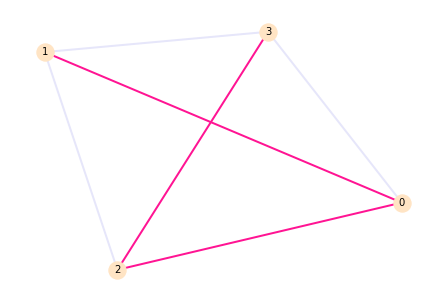

['1', '0', '2', '3']
nr of seqs:
4
new seqs before loop
['attc', None, None, None]
idx:1, i=0
idx:0, i=1
idx:2, i=2
idx:3, i=3
1
seqs new:
['attc', 'atc', 'agt', 'gga']
old seqs:
['atc', 'attc', 'agt', 'gga']
matrix for source node inspo:
[[ 0.  4.  7. 12.]
 [ 4.  0.  9. 16.]
 [ 7.  9.  0.  7.]
 [12. 16.  7.  0.]]
M right now:
[['a'], ['t'], ['c']]
s1 right now:
atc
seqs right now
['atc', 'attc', 'agt', 'gga']
[[ 0.  4.  7. 12.]
 [ 4.  0.  9. 16.]
 [ 7.  9.  0.  7.]
 [12. 16.  7.  0.]]
[['' '4' '0' '1']
 ['' '7' '0' '2']
 ['' '12' '0' '3']
 ['' '9' '1' '2']
 ['' '16' '1' '3']
 ['' '7' '2' '3']]
[['*' '4' '0' '1']
 ['*' '7' '0' '2']
 ['*' '7' '2' '3']
 ['' '9' '1' '2']
 ['' '12' '0' '3']
 ['' '16' '1' '3']]
1


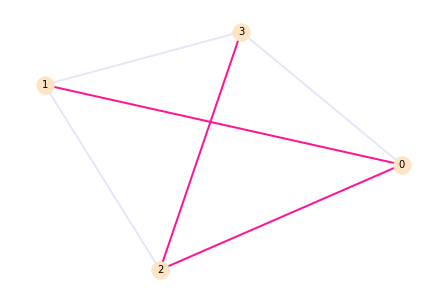

['1', '0', '2', '3']
nr of seqs:
4
new seqs before loop
['attc', None, None, None]
idx:1, i=0
idx:0, i=1
idx:2, i=2
idx:3, i=3
1
seqs new:
['attc', 'atc', 'agt', 'gga']
old seqs:
['atc', 'attc', 'agt', 'gga']
matrix for source node inspo:
[[ 0.  4.  7. 12.]
 [ 4.  0.  9. 16.]
 [ 7.  9.  0.  7.]
 [12. 16.  7.  0.]]
M right now:
[['a'], ['t'], ['c']]
s1 right now:
atc
seqs right now
['atc', 'attc', 'agt', 'gga']


(45,
 [['a', 'a', 'a', 'g'], ['t', 't', 'g', 'g'], ['c', 'c', 't', 'a']],
 array([['', '4', '0', '1'],
        ['', '7', '0', '2'],
        ['', '12', '0', '3'],
        ['', '9', '1', '2'],
        ['', '16', '1', '3'],
        ['', '7', '2', '3']], dtype='<U11'),
 ['1', '0', '2', '3'])

In [252]:
seqs=["atc","attc","agt","gga"]
score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=4
sp_approxi(seqs,score_matrix,gap_cost)



sp_approxi(seqs,score_matrix,gap_cost)
